In [1]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import json 
import os
import glob
import PIL.Image as Image
import copy
import time
import shutil

from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

import selectivesearch

### Load data

#### Change project directory and run once

In [10]:
# Create directories
data_path='/dtu/datasets1/02514/data_wastedetection'
project_path = os.path.join(os.getcwd(), 'Project1.2')
os.mkdir(os.path.join(project_path, 'data'))
os.mkdir(os.path.join(project_path, 'data', 'raw'))
os.mkdir(os.path.join(project_path, 'data', 'splitted'))
os.mkdir(os.path.join(project_path, 'data', 'raw', 'test'))
os.mkdir(os.path.join(project_path, 'data', 'raw', 'train'))
os.mkdir(os.path.join(project_path, 'data', 'splitted', 'train'))
os.mkdir(os.path.join(project_path, 'data', 'splitted', 'train', 'Background'))

annotations = json.load(open(os.path.join('Project1.2/annotations.json')))
supercategories = {}
categories = ['Background']
for i in range(len(annotations['categories'])):
    supercategories[str(i)] = annotations['categories'][i]['supercategory']
    if annotations['categories'][i]['supercategory'] not in categories:
        categories.append(annotations['categories'][i]['supercategory'])
        os.mkdir(os.path.join(project_path, 'data', 'splitted', 'train', annotations['categories'][i]['supercategory']))

In [11]:
for id in range(len(annotations['images'])):
    if int(annotations['images'][id]['file_name'].split('_')[1].split('/')[0]) < 13:
        shutil.copyfile(os.path.join(data_path, annotations['images'][id]['file_name']), os.path.join(project_path, 'data', 'raw', 'train', str(id)+'.jpg'))
    else:
        shutil.copyfile(os.path.join(data_path, annotations['images'][id]['file_name']), os.path.join(project_path, 'data', 'raw', 'test', str(id)+'.jpg'))

In [4]:
def get_iou(bb1, bb2):
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def resize(image, BB, size=1000, aspect=True):
    ### resize image
    if aspect:
        if image.shape[1] > image.shape[0]:
            size = (size, int(size*image.shape[0]/image.shape[1]))
        else:
            size = (int(size*image.shape[1]/image.shape[0]), size)
    else:
        size = (size, size)

    img_resized = cv2.resize(image.copy(), size, interpolation = cv2.INTER_AREA)
            
    ### resize BB
    # get x and y ratio
    lx = size[0]/image.shape[1]
    ly = size[1]/image.shape[0]
    
    # get new (x,y), width, height
    BB_new = [int(BB[0]*lx), int(BB[1]*ly), int(BB[2]*lx), int(BB[3]*ly)]
    
    return img_resized, BB_new

def edgeBoxDetection(image):
    proposals = np.array([])
    model = os.path.join(os.getcwd(), 'Project1.2', 'model.yml')
    edge_detection = cv2.ximgproc.createStructuredEdgeDetection(model)
    edges = edge_detection.detectEdges(np.float32(image) / 255.0)

    orimap = edge_detection.computeOrientation(edges)
    edges = edge_detection.edgesNms(edges, orimap)

    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(2000)
    boxes = edge_boxes.getBoundingBoxes(edges, orimap)

    return boxes[0]

2832.jpg Bottle


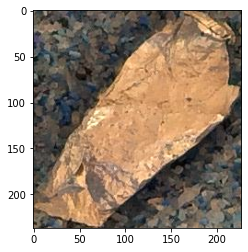

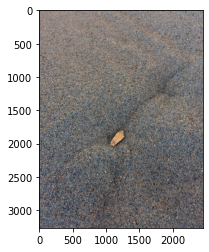

1318.jpg Bottle


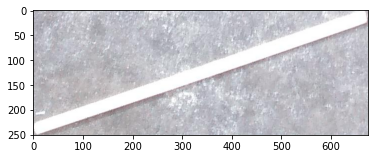

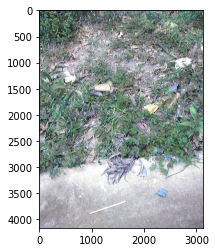

205.jpg Bottle


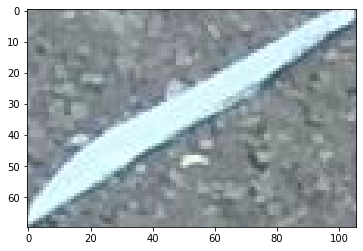

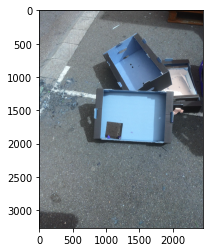

1341.jpg Bottle


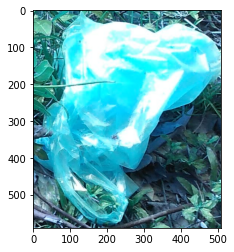

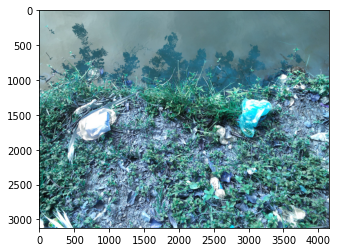

RuntimeError: No active exception to reraise

In [9]:
def resize(image, BB, size=1000, aspect=True):
    ### resize image
    if aspect:
        if image.shape[1] > image.shape[0]:
            size = (size, int(size*image.shape[0]/image.shape[1]))
        else:
            size = (int(size*image.shape[1]/image.shape[0]), size)
    else:
        size = (size, size)

    img_resized = cv2.resize(image.copy(), size, interpolation = cv2.INTER_AREA)
            
    ### resize BB
    # get x and y ratio
    lx = size[0]/image.shape[1]
    ly = size[1]/image.shape[0]
    
    # get new (x,y), width, height
    BB_new = [int(BB[0]*lx), int(BB[1]*ly), int(BB[2]*lx), int(BB[3]*ly)]
    
    return img_resized, BB_new

def edgeBoxDetection(image):
    proposals = np.array([])
    model = os.path.join(os.getcwd(), 'Project1.2', 'model.yml')
    edge_detection = cv2.ximgproc.createStructuredEdgeDetection(model)
    edges = edge_detection.detectEdges(np.float32(image) / 255.0)

    orimap = edge_detection.computeOrientation(edges)
    edges = edge_detection.edgesNms(edges, orimap)

    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(2000)
    boxes = edge_boxes.getBoundingBoxes(edges, orimap)

    return boxes[0]


path_train = os.path.join(os.getcwd(), 'Project1.2', 'data', 'raw', 'train')
size = 224
iou_threshold = 0.5

for cat in categories:
    if cat != 'Background':
        for folder_name in os.listdir(path_train):
            counter = 0
            for image_name in os.listdir(os.path.join(path_train, folder_name)):
                counter += 1
                print(image_name, folder_name)
                image_id = int(image_name.split('.')[0]) - 1
                path = os.path.join(path_train, folder_name, image_name)
                image = cv2.imread(path)

                BB = [
                    int(annotations['annotations'][image_id]['bbox'][0]),
                    int(annotations['annotations'][image_id]['bbox'][1]),
                    int(annotations['annotations'][image_id]['bbox'][0] + annotations['annotations'][image_id]['bbox'][2]), 
                    int(annotations['annotations'][image_id]['bbox'][1] + annotations['annotations'][image_id]['bbox'][3])
                    ]

                # image, BB = resize(image, BB, size=720)

                gt = image[BB[1]:BB[3], BB[0]:BB[2]]
                plt.imshow(gt)
                plt.show()
                plt.imshow(image)
                plt.show()
                if counter > 3: raise 
                # # cv2.imwrite(path.replace('raw', 'splitted'), gt)

                # BB_proposals = edgeBoxDetection(image)
                # images_out_true = []
                # images_out_false = []

                # for proposal in BB_proposals:
                #     proposal = [proposal[0], proposal[1], proposal[0]+proposal[2], proposal[1]+proposal[3]]
                #     iou = get_iou(BB, proposal)
                #     if iou > 0.5:
                #         timage = image[proposal[1]:proposal[3], proposal[0]:proposal[2]]
                #         images_out_true.append(timage)
                #     elif iou < 0.3: 
                #         timage = image[proposal[1]:proposal[3], proposal[0]:proposal[2]]
                #         images_out_false.append(timage)

                # counter = 0
                # for i in range(len(images_out_true)):
                #     cv2.imwrite(os.path.join(path_train, folder_name, str(image_id)+f'_{str(counter)}.jpg').replace('raw', 'splitted'), images_out_true[i])
                #     counter += 1

                # counter = 0
                # for i in range(3*len(images_out_true)):
                #     cv2.imwrite(os.path.join(path_train, folder_name, str(image_id)+f'_{str(counter)}.jpg').replace('raw', 'splitted'), images_out_false[i])
                #     counter += 1

                # for proposal in BB_proposals:
                #     proposal = [proposal[0], proposal[1], proposal[0]+proposal[2], proposal[1]+proposal[3]]
                #     iou = get_iou(BB, proposal)
                #     if iou > 0.5:
                #         timage = image[proposal[1]:proposal[3], proposal[0]:proposal[2]]
                #         cv2.imwrite(os.path.join(path_train, folder_name, str(image_id)+f'_{str(counter)}.jpg').replace('raw', 'splitted'), timage)
                #     else: 
                #         timage = image[proposal[1]:proposal[3], proposal[0]:proposal[2]]
                #         cv2.imwrite(os.path.join(path_train, folder_name, str(image_id)+f'_{str(counter)}.jpg').replace('raw', 'splitted').replace(folder_name, 'Background'), timage)
                #     counter += 1
    

In [9]:
len(BB_proposals)

1000

#### Taco class

Image shape: (256, 256)


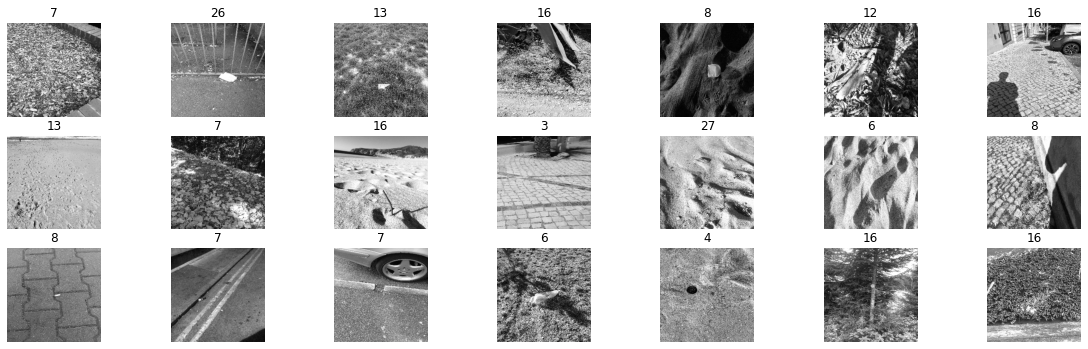

In [59]:
class Taco(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=os.path.join(os.getcwd(), 'Project1.2', 'data', 'raw')):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

batch_size = 64

trans = transforms.Compose([ 
                            transforms.ToTensor(),
                            transforms.Resize((256, 256)),
                            ])

trainset = Taco(train=True, transform=trans)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Taco(train=False, transform=trans)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

print(f"Image shape: {images[0].numpy()[0].shape}")

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

In [60]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Load annotations
annotations = json.load(open(os.path.join('Project1.2', 'annotations.json')))

In [ ]:
# Load images
data_path = '/dtu/datasets1/02514/data_wastedetection/'
images = {}
for image_id in range(len(annotations['images'])):
    images[image_id] = cv2.imread(os.path.join(data_path, annotations['images'][image_id]['file_name']))

In [ ]:
# Get bounding box for every image 
annotations['bounding_boxes'] = {}
for image_id in range(len(annotations['images'])):
    bbxstart = 10000
    bbxfin = 0
    bbystart = 10000
    bbyfin = 0
    for id, value in enumerate(annotations['annotations'][image_id]['segmentation'][0]):
        if id % 2 == 0:
            if bbxstart > value: bbxstart = value
            if bbxfin < value: bbxfin = value
        else:
            if bbystart > value: bbystart = value
            if bbyfin < value: bbyfin = value

    annotations['bounding_boxes'][image_id] = [int(bbxstart), int(bbystart), int(bbxfin), int(bbyfin)]

### Resize images and bounding boxes

In [ ]:
# # Resize images and bounding boxes
# resized_images = []
# annotations['new_bounding_boxes'] = {}
# for image_id in images:
    
#     # Resize images and bounding boxes
#     width = annotations['bounding_boxes'][image_id][2] - annotations['bounding_boxes'][image_id][0]
#     height = annotations['bounding_boxes'][image_id][3] - annotations['bounding_boxes'][image_id][1]
#     new_image, new_bb, new_width, new_height = resize(images[image_id], (annotations['bounding_boxes'][image_id][0], annotations['bounding_boxes'][image_id][1]), width, height)
    
#     # write resized images
#     resized_images.append(new_image)

#     # write new bounding boxes
#     annotations['new_bounding_boxes'][image_id] = [int(new_bb[0]), int(new_bb[1]), int(new_bb[0] + new_width), int(new_bb[1] + new_height)]